In [1]:
#%pip install torch torchvision fastai datasets

In [2]:
# get the python version
import sys
print(sys.version)
is_38 = sys.version_info >= (3, 8)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


In [3]:
import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset
import pandas as pd

In [4]:
pixels = 64

## Dataset

In [5]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import torch.nn.functional as F

class MyDataset(VisionDataset):
    def __init__(
        self,
        root: str = ".",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
        normalize: Tuple[float, float] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        self.labels = [ 'tg', 'Ng', 'Pci', 'H', 'Wp', 'Ph', 'Ox', 'Ow', 'Hbt', 'Wm', 'Wr' ]
        self.ids, self.data, self.features = self._load_data(root, ij=normalize)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # id, img, features = self.ids[index], self.data[index], self.features.iloc[index]
        img, features = self.data[index], torch.Tensor(self.features.iloc[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy().astype(np.uint8))
        

        img = img.reshape(pixels, pixels)
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        img = img.reshape(pixels**2, -1)

        return img, features

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self, root: str, ij: Tuple[float, float]):
        ids = pd.read_csv(f'{root}/PD_ids_train.csv')
        data = pd.read_csv(f'{root}/PD_imgs_np_train.csv')
        features = pd.read_csv(f'{root}/PD_conditions_train.csv')

        # convert all to list
        # TODO something better than a list
        ids = ids.values.tolist()
        data = data.values.tolist()
        features = features.values.tolist()

        # resize the data now
        # TODO hmmmm
        data = torch.Tensor(data)
        # TODO the first byte is bad
        # remove the first column
        data = data[:, 1:]
        # data = data.reshape(len(data), 140, 39).float()
        # TODO do this properly

        # add 16 bytes of padding
        # data = F.pad(data, (0, 16), value=0)
        # data = data.reshape(len(data), 74, 74).float()
        # print(data.shape)
        # # upscale to 128x128
        data = data.reshape(len(data), 140, 39).float()
        # data = F.interpolate(data.unsqueeze(1), size=(128, 128), mode='nearest').squeeze(1)
        # data = F.interpolate(data.unsqueeze(1), size=(128, 39), mode='nearest').squeeze(1)
        # data = F.pad(data, (0, 128-39), value=0)
        # data = F.interpolate(data.unsqueeze(1), size=(140, 39*3), mode='nearest').squeeze(1)
        data = F.interpolate(data.unsqueeze(1), size=(64, 64), mode='nearest').squeeze(1)
        # repeat every pixel 3 times along the width
        """
        [1, 2, 3] => [1, 1, 1, 2, 2, 2, 3, 3, 3]
        """
        # data = data.repeat_interleave(3, dim=2)
        # print the first row of the first image


        data = 2 * (data / 255) - 1
        # print(data.shape)
        # print(data[0, 5, :])

        # 140x39 => 140*39=2^n^2 => sqrt(140*39) = 2^n => 73.8918128076 = 2^n => log2(ceil(73.8918128076)) = n => ceil(6.2094533656) = n
        # -_- i dont want nearest base2, but nearest square
        # 140*39 => ceil(sqrt(140*39)) = 74
        # way less fun, but better
        # 140*39 - 74*74 = 16B of padding

        # data = F.interpolate(data.unsqueeze(1), size=(128, 39), mode='nearest').squeeze(1)
        # TODO what
        data = data.reshape(len(data), -1)
        # data = F.pad(data, (0, 4), value=-1)

        # NOTE convert features to dtype f32 for mps
        features = pd.DataFrame(features, columns=self.labels).astype('float32')

        if ij is not None:
            # drop fields that are not used
            features = features.drop(columns=['H', 'Wp', 'Wm', 'Wr'])

            # NOTE: (-1, 1) => y = 2 * (x - min) / (max - min) - 1
            #       ( i, j) => y = (j-i) * (x - min) / (max - min) + i
            features = (ij[1] - ij[0]) * (features - features.min()) / (features.max() - features.min()) + ij[0]
            # NOTE: they are nan because the min and max are the same, std is 0 (and mean is normally NaN); so we can just set them to 0
            features = features.fillna(0)

        return ids, data, features

### Why the Fancy Normalization Magic

In [6]:
dataset = MyDataset(root='data')

In [7]:
# get the count, mean, std, min, max, and sum of each column
df_aggregated = dataset.features.agg(['count', 'mean', 'std', 'min', 'max', 'sum']).reset_index()
display(df_aggregated)

,index,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,count,668.000000,668.000000,668.000000,668.0,668.0,668.000000,668.000000,668.000000,668.000000,668.000000,6.680000e+02
1,mean,333.500000,68.757767,38.844311,0.0,0.0,327.544922,25.612276,5.974551,1456.753296,12.200080,3.087517e+05
2,std,192.978683,52.810455,61.393684,0.0,0.0,61.626938,3.267343,2.021089,20.019684,0.000080,1.282210e+00
3,min,0.000000,0.000000,0.000000,0.0,0.0,300.000000,21.000000,3.000000,1410.000000,12.200000,3.087504e+05
4,max,667.000000,200.000000,200.000000,0.0,0.0,500.000000,30.000000,9.000000,1485.000000,12.200000,3.087504e+05
5,sum,222778.000000,45930.199219,25948.000000,0.0,0.0,218800.000000,17109.000000,3991.000000,973106.937500,8149.598633,2.062453e+08


In [8]:
# normalize each column
df_normalized = (dataset.features - dataset.features.mean()) / dataset.features.std()
display(df_normalized)

# make the values between -1 and 1
df_normalized = (dataset.features - dataset.features.mean()) / dataset.features.std()
df_normalized = 2 * (df_normalized - df_normalized.min()) / (df_normalized.max() - df_normalized.min()) - 1
display(df_normalized)

,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,-1.728170,1.538374,-0.632709,NaN,NaN,2.798372,-0.493452,1.002157,0.152188,-0.999251,-0.999251
1,-1.722988,0.970305,-0.632709,NaN,NaN,2.798372,1.342903,-1.471756,0.152188,-0.999251,-0.999251
2,-1.717806,-1.301973,0.507474,NaN,NaN,-0.446962,0.424726,-0.482191,0.152188,-0.999251,-0.999251
3,-1.712624,-1.301973,1.810539,NaN,NaN,-0.446962,1.342903,1.496940,0.152188,-0.999251,-0.999251
4,-1.707443,1.538374,-0.632709,NaN,NaN,-0.446962,1.342903,0.012592,0.152188,-0.999251,-0.999251
...,...,...,...,...,...,...,...,...,...,...,...
663,1.707443,-0.584312,-0.632709,NaN,NaN,2.798372,0.424726,-0.482191,0.152188,-0.999251,-0.999251
664,1.712624,-0.923260,-0.144059,NaN,NaN,-0.446962,-1.411629,0.012592,0.152188,-0.999251,-0.999251
665,1.717806,-0.582418,-0.632709,NaN,NaN,-0.446962,0.424726,-0.976974,-2.335366,-0.999251,-0.999251
666,1.722988,0.591592,1.810539,NaN,NaN,-0.446962,1.342903,1.002157,0.152188,-0.999251,-0.999251


,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,-1.000000,0.500,-1.0,NaN,NaN,1.0,-0.333333,6.666665e-01,0.328001,NaN,NaN
1,-0.997002,0.200,-1.0,NaN,NaN,1.0,1.000000,-1.000000e+00,0.328001,NaN,NaN
2,-0.994003,-1.000,-0.3,NaN,NaN,-1.0,0.333333,-3.333334e-01,0.328001,NaN,NaN
3,-0.991005,-1.000,0.5,NaN,NaN,-1.0,1.000000,1.000000e+00,0.328001,NaN,NaN
4,-0.988006,0.500,-1.0,NaN,NaN,-1.0,1.000000,-5.960464e-08,0.328001,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
663,0.988006,-0.621,-1.0,NaN,NaN,1.0,0.333333,-3.333334e-01,0.328001,NaN,NaN
664,0.991004,-0.800,-0.7,NaN,NaN,-1.0,-1.000000,-5.960464e-08,0.328001,NaN,NaN
665,0.994003,-0.620,-1.0,NaN,NaN,-1.0,0.333333,-6.666667e-01,-1.000000,NaN,NaN
666,0.997002,0.000,0.5,NaN,NaN,-1.0,1.000000,6.666665e-01,0.328001,NaN,NaN


In [9]:
# get the unique values of eatch column in the dataset
# df_unique = dataset.features.apply(lambda x: x.unique())
# display(df_unique)
# get the length of each unique value
df_unique_len = dataset.features.apply(lambda x: len(x.unique()))
display(df_unique_len)

tg     668
Ng      17
Pci     18
H        1
Wp       1
Ph       3
Ox       6
Ow       7
Hbt      3
Wm       1
Wr       1
dtype: int64

### Viewing the Data


data: tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])
features: tensor([-1.0000,  0.5000, -1.0000,  1.0000, -0.3333,  0.6667,  0.3280])

(1, 64, 64)


,tg,Ng,Pci,H,Ox,Ow,Hbt
0,-1.0,0.5,-1.0,1.0,-0.333333,0.666667,0.328001


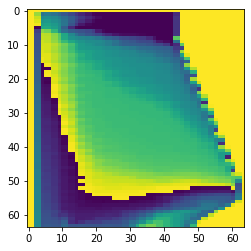

In [10]:
dataset = MyDataset(root='data', normalize=(-1, 1))
datum = dataset[0]
print(f"""
data: {datum[0]}
features: {datum[1]}
""")

# convert data to image plot
# TODO first pixel is bad
img = np.array(datum[0])
# img = img.reshape(-1, 128, 128)
# img = Image.fromarray((img * 255).astype(np.uint8)[0])
# plt.imshow(img)
# img2 = np.array(datum[0])
# img2 = img2[:-16].reshape(140, 39)
# plt.imshow(img2)

# downscale to 74x74
# remove the padding
# img = img[:-4].reshape(-1, 140, 39*3)
img = img.reshape(-1, pixels, pixels)
# img = F.interpolate(torch.Tensor(img).unsqueeze(0), size=(140, 39), mode='nearest').squeeze(0).numpy()
print(img.shape)
img = Image.fromarray((img * 255).astype(np.uint8)[0])
plt.imshow(img)

# convert features to dataframe
# TODO not correct, but ai guessed the labels, so its funny
# Ng = Nitrogen, Pci = Pesticide, H = Humidity, Wp = Watering pattern, Ph = pH, 0x = 0x, 0w = 0w, Hbt = Habitat, Wm = Weed management, Wr = Weather
labels = [ 'tg', 'Ng', 'Pci', 'H', 'Wp', 'Ph', 'Ox', 'Ow', 'Hbt', 'Wm', 'Wr' ]
labels = [ 'tg', 'Ng', 'Pci', 'H', 'Ox', 'Ow', 'Hbt' ]
conditions = np.array(datum[1])
features = pd.DataFrame([conditions], columns=labels)
display(features)

In [11]:
# get the count, mean, std, min, max, and sum of each column
df_aggregated = dataset.features.agg(['count', 'mean', 'std', 'min', 'max', 'sum']).reset_index()
display(df_aggregated)

,index,tg,Ng,Pci,Ph,Ox,Ow,Hbt
0,count,6.680000e+02,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
1,mean,-1.766725e-08,-0.312423,-0.611557,-0.724551,0.024950,-0.008483,0.246589
2,std,5.786485e-01,0.528105,0.613937,0.616267,0.726076,0.673697,0.533858
3,min,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,max,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,sum,-1.525879e-05,-208.697998,-408.519989,-484.000000,16.666679,-5.666660,164.720627


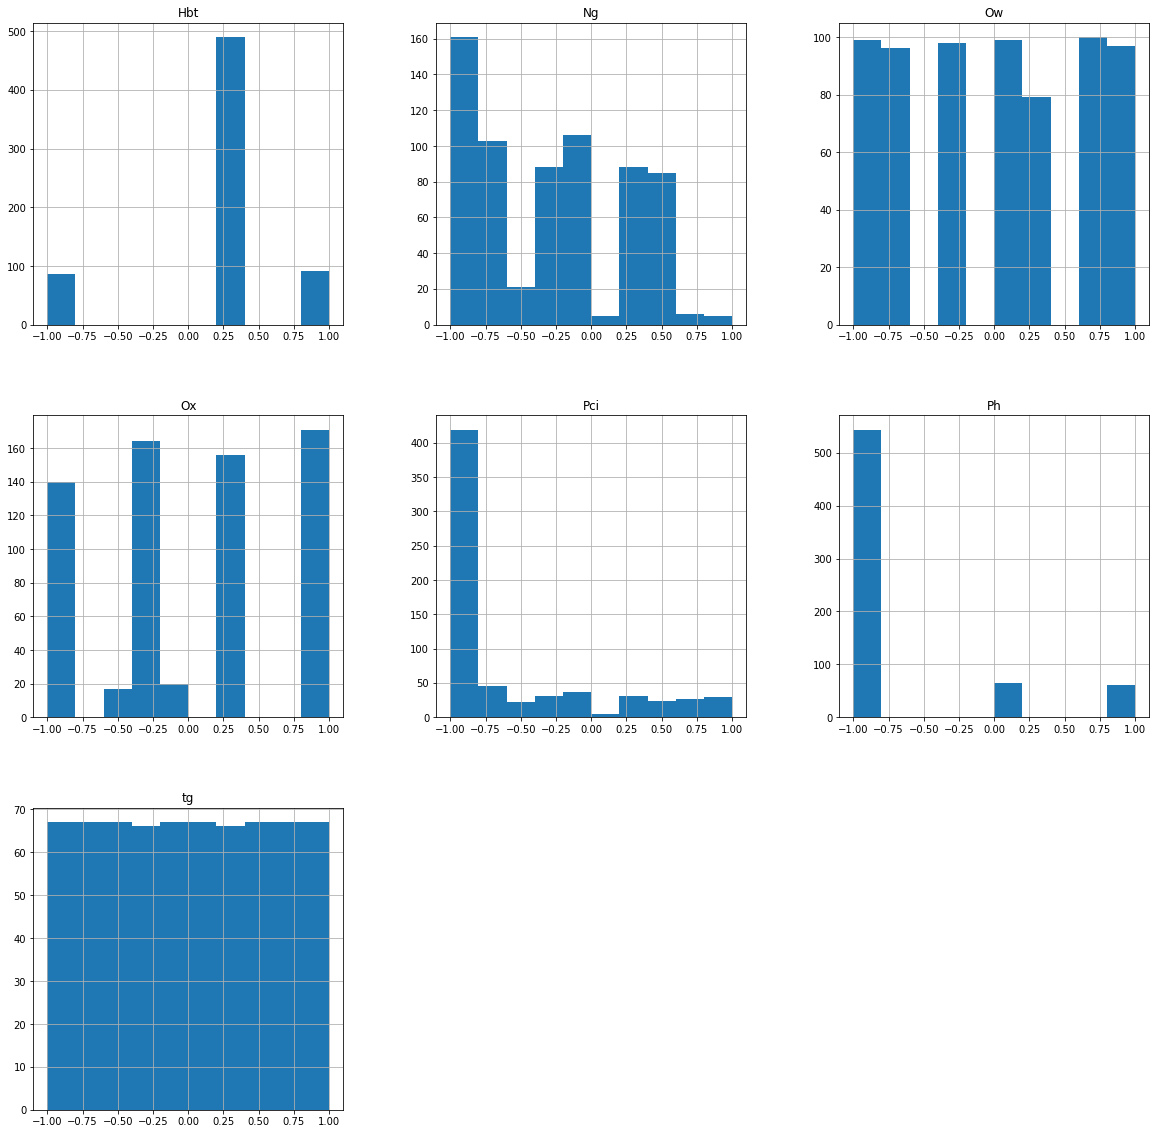

In [12]:
# create a histogram of each column
dataset.features.hist(figsize=(20, 20))
plt.show()

In [13]:
# get the memory usage so far
print(f"Memory usage: {dataset.features.memory_usage().sum()} bytes")

Memory usage: 18832 bytes


## CGAN

In [14]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [16]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [17]:
from datasets import load_dataset, Split

In [18]:
import torch.autograd as autograd

In [19]:
channels = 1 ## 1 for B&W, 3 for RGB, 4 for RGBA

learning_rate    = 2e-4 #0.003  ## Adam default   ## 0.001 2e-4#
batch_size       = 16
N_Epochs         = 3000 #4_000  ##27000  
num_classes = 1
width = 39
height = 140
img_size = width*height*channels
certainty_repeater = 6# channels**2 - num_classes

print(f"{img_size}")

if torch.cuda.is_available():
    device = torch.device('cuda')
    # get number of cuda devices
    print(f"devices: {torch.cuda.device_count()}")
    print(f"device:  {torch.cuda.get_device_name()}")
    print(f"device0: {torch.cuda.get_device_properties(0)}")
    print(f"{torch.cuda.memory_summary()}")
elif torch.backends.mps is not None:
    device = torch.device('mps')
    print(f"{torch.mps.current_allocated_memory()}")
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device}")

5460
devices: 1
device:  NVIDIA A30
device0: _CudaDeviceProperties(name='NVIDIA A30', major=8, minor=0, total_memory=24049MB, multi_processor_count=56)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|-------------------------------------------------------------------

In [20]:
# convert the dataset into a train / test split
# TODO i dont think test is used
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])

# define the dataloader
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [21]:

def plot_GAN_losses(list_losses_critic, list_losses_generator):
    the_epochs = [i for i in range(len(list_losses_critic))]  

    plt.plot(the_epochs, list_losses_critic,      label = "critic") 
    plt.plot(the_epochs, list_losses_generator,  label = "generator")
    plt.legend() 
    plt.show()


In [22]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [23]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 ).to(device)
    return rand_vec

In [25]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) ).to(device)
    return rand_vec

In [26]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, num_classes ) ).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [27]:
import datetime

list_losses_critic    = []
list_losses_generator    = []

import tqdm

def training_loop(N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt, checkpoint='checkpoint', save_interval: int = None, stop_after: datetime.timedelta = None):
    start_time = datetime.datetime.now()
    pbar = tqdm.tqdm(range(N_Epochs+1))

    for epoch in pbar:
        # shuffle dl_train every epoch
        # dataset = MyDataset(root='data', normalize=(-1, 1), transform=transforms.Compose([
        #     transforms.RandomHorizontalFlip(),
        #     transforms.RandomVerticalFlip()
        # ]))
        # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])
        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for xb, yb in dl_train:              ## xb = [batch, 1, 28, 28]
            xb, yb = xb.to(device), yb.to(device)
            # print the memory usage of mps

            if xb.shape[0] != batch_size:
                # print(f"skipping batch of size {xb.shape[0]}")
                continue

            # xb = xb.reshape(batch_size, 128, width)
            # xb = F.pad(xb, (0, 128-width, 0, 0), value=-1) # TODO set to min
            yb = yb.repeat(1, 3)
            xb = xb.reshape(batch_size, pixels, pixels)
            xb = torch.unsqueeze(xb, dim=1)
            # pad the image to 140x140
            # convert nb [batch, 384] to [batch, -1, 32, channels]

            yb_certainty = yb.repeat(channels, pixels, 1, 1).permute(2, 0, 1, 3)#1, 0, 2) # [ batch, x (classes), y, channels ]
            # yb_certainty = nb.reshape(batch_size, channels, pixels, -1)
            real = torch.cat( (xb, yb_certainty) , dim=3)
            # print the real image
            # plt.imshow(real[0].squeeze(0).cpu().detach().numpy())

            # print the real image TODO this will print nothing because it is normalized to highest number
            # plt.imshow(real[0].squeeze(0).cpu().detach().numpy())

            for _ in range(5):
                noise = torch.cat( (random_G_batch_vector_input(), yb) , dim=1)
                fake = G_model( noise )#.detach()
                real_pred = D_model( real  ).reshape(-1)
                inputs = torch.cat( (fake, yb_certainty) , dim=3)
                fake_pred = D_model(  inputs  ).reshape(-1)

                fake_loss   = D_loss_fn(D_model, inputs, real, real_pred, fake_pred)
                # D_opt.zero_grad()
                D_model.zero_grad()
                fake_loss.backward(retain_graph=True)
                D_opt.step()
                
            output = D_model( inputs ).reshape(-1)
            gen_loss = -torch.mean(output)
            G_model.zero_grad()
            gen_loss.backward()
            G_opt.step()


        if epoch % 1 == 0:
            list_losses_generator.append(        gen_loss.cpu().detach().numpy()  )
            list_losses_critic.append(        fake_loss.cpu().detach().numpy()  )
            D_gen_loss_rnd = np.round(gen_loss.cpu().detach().numpy(), 3)
            D_fake_loss_rnd = np.round(fake_loss.cpu().detach().numpy(), 3)

            # not rounded anymore :(
            message = f"gen: {D_gen_loss_rnd}; crit: {D_fake_loss_rnd}"
            pbar.set_description(message)
            
        # draw an image of each class
        # place them all on the same figure
        if epoch % 100 == 0:
            f, axarr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
            
            for i in range(2):
                label = dataset[i][1].unsqueeze(0).repeat(1, 3).to(device)

                # create noise and make it 2d
                noise = random_G_vector_input().unsqueeze(0)
                inputs = torch.cat( (noise, label) , dim=1)
                output = G_model( inputs ).squeeze(0).cpu()
                # convert output (batch, img_size) to (batch, 4, 32, 32)
                if channels == 4 or channels == 3:
                    # output = output.reshape((-1, 4, pixels, pixels)) # wrong too, lol
                    output = output.reshape((-1, channels, pixels, pixels))
                    # output = output.reshape((-1, 32, 32))

                    img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(32,32)
                elif channels == 1:
                    img = output.detach().numpy()

                if channels == 4 or channels == 3:
                    mode = None
                elif channels == 1:
                    mode = 'L'

                # downscale to 74x74
                # TODO is this the best way, seems like the model gives a different output
                # 128x128 => 128*128 => 128*128-4 => 1x1x140x39*3 => 140x39
                # img = img.reshape(-1)[:-4].reshape(-1, channels, 140, 39*3)
                # img = F.interpolate(torch.Tensor(img), size=(140, 39), mode='nearest').squeeze(0).numpy()
                # remove the padding
                # img = img[:-16].reshape(-1, 140, 39)
                # img = img.reshape(-1)[:-4].reshape(-1, 140, 39*3)
                img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)
                # display the image
                axarr[i].imshow(img)

                # show the original image
                img = dataset[i][0].reshape(-1, pixels, pixels).cpu().detach().numpy()
                # img = img[:-4].reshape(-1, 140, 39*3)
                # img = F.interpolate(torch.Tensor(img).unsqueeze(0), size=(140, 39), mode='nearest').squeeze(0).numpy()
                axarr[i+2].imshow(Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode))
            plt.show()
            # save the plot
            plt.savefig(f"{checkpoint}/epoch_{epoch}.png")
        
        if save_interval is not None and epoch % save_interval == 0:
            torch.save(G_model.state_dict(), f"{checkpoint}/G_{epoch}.pt")
            torch.save(D_model.state_dict(), f"{checkpoint}/D_{epoch}.pt")
            # TODO save evrything else
        
        if stop_after is not None and datetime.datetime.now() > start_time+stop_after:
            print(f"Stopping training because it has been {datetime.datetime.now() - start_time} since {start_time}")
            break

    torch.save(G_model.state_dict(), f"{checkpoint}/G_{epoch}.pt")
    torch.save(D_model.state_dict(), f"{checkpoint}/D_{epoch}.pt")
    # TODO save evrything else

In [28]:
def grad_penatly(critic, real, fake):
    # Random weight term for interpolation between real and fake samples
    batch, c, h, w = real.shape
    epsilon = torch.rand((batch, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Take the norm of the gradient
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1) # L2 norm (euclidean norm)
    gradient_penalty = torch.mean((grad_norm - 1) ** 2)
    return gradient_penalty

In [29]:
def wasserstein_loss(D_model, gen_img, real_data, real_pred, fake_pred):
    loss =  - (real_pred.mean() - fake_pred.mean()) + 10 * grad_penatly(D_model, real_data, gen_img)
    return loss

In [30]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 1, 1),
            self._block(features_d * 2, features_d * 4, 4, 1, 1),
            self._block(features_d * 4, features_d * 8, 4, 1, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=2, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.critic(x)

Sequential(
  (0): AddChannels()
  (1): ConvLayer(
    (0): ConvTranspose2d(121, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): ConvLayer(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): ConvLayer(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1,

gen: -0.012000000104308128; crit: 1.430999994277954:   0%|          | 0/3001 [00:11<?, ?it/s]

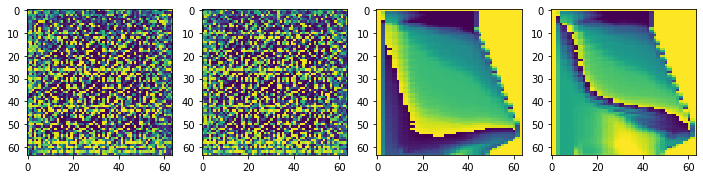

gen: 0.15399999916553497; crit: 0.0:   7%|▋         | 200/3001 [36:05<8:22:47, 10.77s/it]                    

<Figure size 432x288 with 0 Axes>

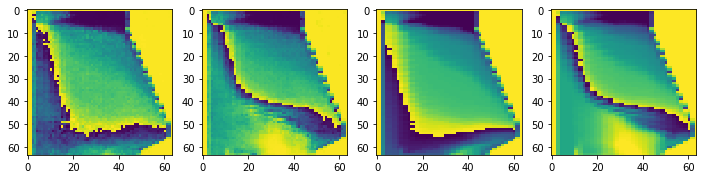

gen: 0.6579999923706055; crit: 0.003000000026077032:  10%|▉         | 300/3001 [54:02<8:04:31, 10.76s/it]  

<Figure size 432x288 with 0 Axes>

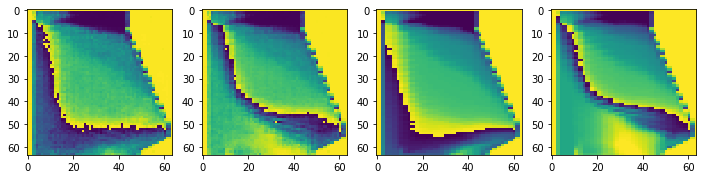

gen: 0.8209999799728394; crit: 0.0010000000474974513:  13%|█▎        | 400/3001 [1:11:58<7:46:42, 10.77s/it]

<Figure size 432x288 with 0 Axes>

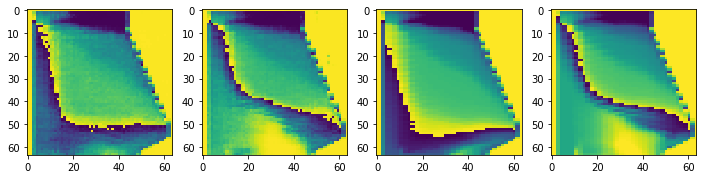

gen: 0.8769999742507935; crit: -0.0:  23%|██▎       | 700/3001 [2:05:49<6:52:46, 10.76s/it]                 

<Figure size 432x288 with 0 Axes>

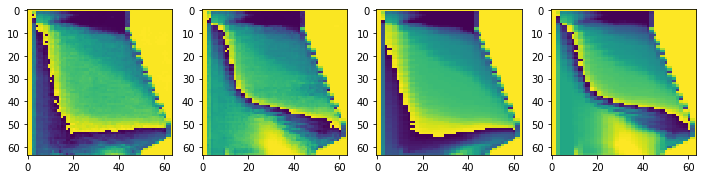

gen: 0.6159999966621399; crit: 0.0:  27%|██▋       | 800/3001 [2:23:46<6:34:46, 10.76s/it]                  

<Figure size 432x288 with 0 Axes>

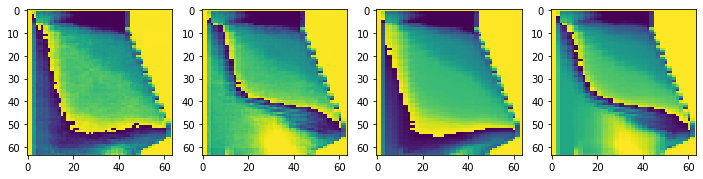

gen: 0.8360000252723694; crit: 0.0:  30%|██▉       | 900/3001 [2:41:42<6:16:54, 10.76s/it]                  

<Figure size 432x288 with 0 Axes>

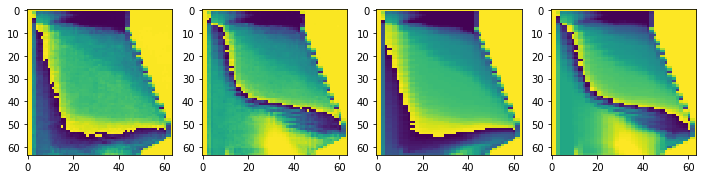

gen: 0.8040000200271606; crit: -0.0:  33%|███▎      | 1000/3001 [2:59:39<5:58:55, 10.76s/it]                

<Figure size 432x288 with 0 Axes>

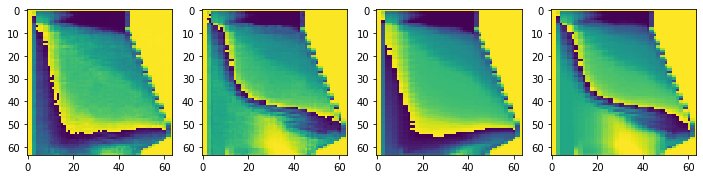

gen: 0.906000018119812; crit: 0.0:  37%|███▋      | 1100/3001 [3:17:35<5:41:03, 10.76s/it]                   

<Figure size 432x288 with 0 Axes>

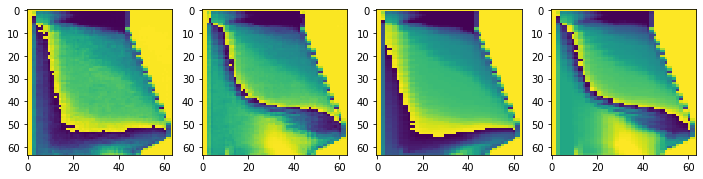

gen: 0.9369999766349792; crit: -0.0:  39%|███▉      | 1170/3001 [3:30:09<5:28:53, 10.78s/it]                 

Stopping training because it has been 3:30:09.879331 since 2024-06-08 09:35:34.731774


<Figure size 432x288 with 0 Axes>

In [31]:
G_model     =  basic_generator(pixels, in_sz=100+7*3, n_channels=channels, n_extra_layers=1)# Generator_Net()
print(G_model)
# G_model     = Generator_DL_Net()

# TODO try 32x32 and doubling kernel, stride

# D_model     =    basic_critic(
#                     pixels, 
#                     n_channels=channels, 
#                     n_extra_layers=1, 
#                     act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
# )#

D_model     = Critic(channels_img=channels, features_d=pixels)

# D_model = CriticNet()

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn = wasserstein_loss
# use a loss function that supports values between -1 and 1
# D_loss_fn = nn.BCEWithLogitsLoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )

# move everything to device
G_model.to(device)
D_model.to(device)
# D_loss_fn.to(device)

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt,
    checkpoint='checkpoint', save_interval=100, stop_after=datetime.timedelta(hours=3, minutes=30)   )

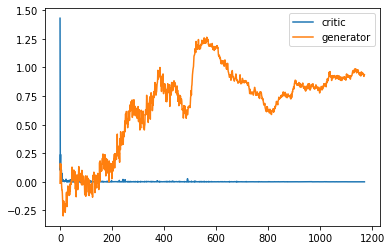

In [32]:
plot_GAN_losses(list_losses_critic, list_losses_generator)

In [33]:
G_model     =  basic_generator(pixels, in_sz=100+7*3, n_channels=channels, n_extra_layers=1).to(device)
G_model.load_state_dict(torch.load('checkpoint/G_123.pt'))

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "6.weight". 
	Unexpected key(s) in state_dict: "6.0.weight", "6.1.weight", "6.1.bias", "6.1.running_mean", "6.1.running_var", "6.1.num_batches_tracked", "7.weight". 
	size mismatch for 1.0.weight: copying a param with shape torch.Size([121, 1024, 4, 4]) from checkpoint, the shape in current model is torch.Size([121, 512, 4, 4]).
	size mismatch for 1.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 1.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 1.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 1.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 2.0.weight: copying a param with shape torch.Size([1024, 512, 4, 4]) from checkpoint, the shape in current model is torch.Size([512, 256, 4, 4]).
	size mismatch for 2.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 2.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 2.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 2.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 3.0.weight: copying a param with shape torch.Size([512, 256, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 128, 4, 4]).
	size mismatch for 3.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 3.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 3.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 3.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 4.0.weight: copying a param with shape torch.Size([256, 128, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for 4.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 4.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 4.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 4.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for 5.0.weight: copying a param with shape torch.Size([128, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        rand = random_G_vector_input().unsqueeze(0)

        label = dataset[0][1].to(device).unsqueeze(0).repeat(1, 3)
        noise = torch.cat( (rand, label) , dim=1)
        fake = G_model.forward( noise ).cpu()
        img = fake.squeeze(0).detach().numpy()

        # print(img.shape)
        # convert img to pil
        # img = img.reshape(-1)[:-4].reshape(-1, channels, 140, 39*3)
        img = img.reshape(-1).reshape(-1, pixels, pixels)
        # img = F.interpolate(torch.Tensor(img), size=(140, 39), mode='nearest').squeeze(0).numpy()
        img = Image.fromarray((img * 255).astype(np.uint8)[0], mode='L')
        # display the image
        # plt.imshow(img)
        axarr[i,j].imshow(img)#, interpolation='none', cmap='Blues'

        # TODO print comparison